In [1]:
import glob
import io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skimage import io as sk_io
from pathlib import Path
from typing import Any, Union, Optional  # Meta
from typing import Iterable, Sequence, Mapping, MutableMapping  # Generic ABCs
from typing import Tuple, List  # Generic

from PIL import Image
import re
import logging
from anndata import AnnData
import cv2
import duallog
import scanpy as sc
import scanpy.external as sce
from shapely.geometry import MultiPoint, Point, Polygon,LineString, MultiPolygon
from matplotlib.pyplot import rc_context
import seaborn as sns
import matplotlib.patches as mpatches
import tifffile
# from pathlib import Path

In [2]:
from utils import *
from param import *

In [3]:
import scanpy as sc

In [4]:
def inverse_transform_multiple_points(xform, points):
    transformed_points = list()
    for point in points: 
        result, state = inverse_transform_point(xform, point)
        transformed_points.append(result)
    return transformed_points

def pairs(list_combine):
    perm_pairs = list()
    for i in range(len(list_combine)):
        for j in range(i+1, len(list_combine)):
            perm_pairs.append(re.sub('\+','',list_combine[i])+'_'+ re.sub('\+','',list_combine[j]))
    
    return perm_pairs


In [5]:
def colocalised_count(df, group_col = 'Colocal_window',list_col='cell_type'):
    keys, values = df[[group_col,list_col]].sort_values(group_col).values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    col_value = dict()
    for col in np.unique(df[list_col]):
        col_value[col] =list()
        for item in arrays:
            count = (item==col).sum()
            col_value[col].append(count)
#     df2 = pd.DataFrame({group_col:ukeys, list_col:[list(a) for a in arrays]})
    df2 = pd.DataFrame(col_value,index=ukeys)
    return df2


def convert_micron2pixel(x_micron, micron_dim, scale_dim):
    """ convert the annotation box coordinate from micron unit to pixel unit
    
    ox_px_coord = convert_micron2pixel(ox_coords, 6276.93, im_demo.shape[1])
    oy_px_coord = convert_micron2pixel(oy_coords, 15235.53, im_demo.shape[0])
    """
    return (x_micron*scale_dim/micron_dim)

def add_detection_boxes(list_annots, current_ox, current_oy, 
                        current_width, current_height, 
                        sub_h_size=0.5, sub_w_size=0.5,):
    numb_w_subbox = int(1/sub_w_size)
    numb_h_subbox = int(1/sub_h_size)
    sub_annot_width, sub_annot_height = int(current_width * sub_w_size), int(current_height * sub_h_size)
#         list_annots = list()
    for idx_w in range(numb_w_subbox):
        for idx_h in range(numb_h_subbox):
            stride_x = idx_w * sub_annot_width
            stride_y = idx_h * sub_annot_height
            tmp_rect = [stride_x+current_ox, 
                        stride_y+current_oy, 
                        stride_x+current_ox+sub_annot_width, 
                        stride_y+current_oy+sub_annot_height]
            list_annots.append(tmp_rect)

def map_heat_values2colors(values):
    from collections import OrderedDict
    colors = list()
    sorted_values = np.sort(values, kind='mergesort')
    set_box_scores = list(OrderedDict.fromkeys(sorted_values).keys())
    heat_colors_range = sns.color_palette('viridis', len(set_box_scores))
    for value in values:
        raw_color = heat_colors_range[set_box_scores.index(value)]
        colors.append(raw_color)
    return np.array(colors)
    
def list_to_int(list1D):
    """ convert list of float values to integer values """
    return [int(float(x)) for x in list1D]

def draw_rectangles(img, rects, color=(0, 255, 255), thickness=7):
    """ draw rectangles to a cv2 img 
    img: cv2 image in 2D/3D array
    rects: list of rectangle coordinates top, left, bottom, right
    color: rectangle color
    thickness: the thickness of 4 edges
    """
#     print(img.shape)
    clone_image = img.copy()
    for rect in rects:
        pt1 = tuple(list_to_int(rect[0:2]))
        pt2 = tuple(list_to_int(rect[2:]))
#         print(pt1, pt2)
        cv2.rectangle(clone_image, pt1, pt2, color, thickness, cv2.FILLED)
    return clone_image

def draw_rectangles_heat(img, rects:dict, colors:list, thickness=0):
    """Plot the spatial heatmap of cell colocalization score"""
    clone_image = img.copy()
    for index, rect in enumerate(rects):
        pt1 = np.array(list_to_int(rect[0:2]))
        pt2 = np.array(list_to_int(rect[2:]))
        cv2.rectangle(clone_image, tuple(pt1-thickness), tuple(pt2+thickness), colors[index], cv2.FILLED)
    return clone_image


class STRISH_Obj(AnnData):
    
    def __init__(
        self, 
        cnt_matrix: pd.DataFrame, 
        meta_vars: pd.DataFrame, 
        ref_image: Optional[np.ndarray],
        polygon: Optional[Union[pd.DataFrame, Mapping[str, Sequence[Polygon]]]]=None,
        is_view: bool=False
    ):
        super().__init__(cnt_matrix, asview=is_view)
        self.obs = meta_vars
        self._polygon = polygon
        self._ref_image = ref_image
        for col in meta_vars.columns: 
            if re.match(r'^Centroid\s+(.*)', col):
                if 'X' in col:
                    self.__centroid_X = col
                if 'Y' in col:
                    self.__centroid_Y = col
                self._original_coord_unit = re.sub('^[X|Y]+\s', '' ,re.findall(r'^Centroid\s+(.*)', col)[0])
        self._ref_image_unit = 'px'

    def _gen_repr(self, n_obs, n_vars) -> str:
        if self.isbacked:
            backed_at = f" backed at {str(self.filename)!r}"
        else:
            backed_at = ""
        descr = f"STRISH object with n_obs × n_vars = {n_obs} × {n_vars}{backed_at}"
        for attribute in [
            "obs",
            "var",
            "uns",
            "obsm",
            "varm",
            "layers", 'colocalized_scores' , 'colocalized_boxes',
            "obsp", 'all_rects', 'areas', 'contours',
            "varp",'ref_image','original_coord_unit','ref_image_unit',
        ]:
            if hasattr(self, attribute):
                if isinstance(getattr(self, attribute), pd.DataFrame):
                    keys = getattr(self, attribute).keys()
                    if len(keys) > 0:
                        descr += f"\n {attribute}: {str(list(keys))[1:-1]}"
                elif isinstance(getattr(self, attribute), np.ndarray):
                    descr += f"\n {attribute}: {getattr(self, attribute).shape}"
                elif isinstance(getattr(self, attribute), str):
                    descr += f"\n {attribute}: {getattr(self, attribute)}"
#                 else:
#                     descr += f"\n {attribute}: {type(getattr(self, attribute))}"
        return descr
    
    
    def __repr__(self):
        if self.is_view:
            return "View of " + self._gen_repr(self.n_obs, self.n_vars)
        else:
            return self._gen_repr(self.n_obs, self.n_vars)
        
    def __getitem__(self, index) -> 'STRISH_Obj':
        oidx, vidx = self._normalize_indices(index)
        tmp = AnnData(self, oidx=oidx, vidx=vidx, asview=True)
        data = tmp.copy()
        logging.warning('Slice of data')
        cached_polygon = None
        if self._polygon:
            cached_polygon = self.polygon.iloc[vidx]
        observe_df = data.obs.replace({np.nan: None})
        strish_item = STRISH_Obj(data.to_df(), observe_df, ref_image=self.ref_image, polygon=cached_polygon, is_view=False)
#         for attribute in [
#             "uns",
#             "obsm",
#             "varm",
#             "obsp", 'all_rects', 'areas',
#             "varp"
#         ]:
#             if hasattr(self, attribute):
#                 setattr(strish_item, attribute, getattr(self, attribute))
        return strish_item
    
    
    def copy(self) -> "STRISH_Obj":
        """Full copy, optionally on disk."""
        return STRISH_Obj(self.to_df(), self.obs, ref_image=self.ref_image, polygon=self.polygon, is_view=False)
    
    @property
    def polygon(self): 
        """A Dataframe stores the metadata of the cells including coordination, cell type, tissue id etc"""
        return self._polygon
    
    
    @property
    def ref_image(self):
        """stores the image that will be used as the reference of analysis and plot the result"""
        return self._ref_image
    
    @ref_image.setter
    def ref_image(self, value:Union[np.ndarray]):
        assert isinstance(value, (np.ndarray, Image)), 'Check the image type'
        self._ref_image = value
    
    @property 
    def original_coord_unit(self): 
        """ the dataframe or ndarray to store the count matrix of all cells"""
        return self._original_coord_unit
    
    @property 
    def ref_image_unit(self): 
        """ the dataframe or ndarray to store the count matrix of all cells"""
        return self._ref_image_unit
    
    def plot_expression_histogram(self, figsize:Union[int,tuple]=(15,15), save_fn:Optional[str]=None):
        """ Visualization of the expression of every existing marker accross all the cell """
        if isinstance(figsize, tuple) and len(figsize) == 2:
            self.to_df().hist(column=self.to_df().columns, bins=50, figsize=figsize)
        elif isinstance(figsize, int):
            self.to_df().hist(column=self.to_df().columns, bins=50, figsize=(figsize, figsize))
        else:
            raise Exception(f'figsize is invalid {type(figsize)}, only support int or tuple format')
        if save_fn:
            plt.savefig(save_fn)
            
    def plot_size_shape_histogram(self, colums:Optional[Union[str, list]]=None,figsize:Union[int,tuple]=(15,15), save_fn:Optional[str]=None):
        """ Visualization of the cell's size and shape accross all the cells """
        plot_columns = None
        if colums: 
            plot_columns = colums
        else:
            plot_columns = [col for col in self.obs.columns if 'Nucleus' in col]
        if isinstance(figsize, tuple) and len(figsize) == 2:
            self.obs.hist(column=plot_columns, bins=50, figsize=figsize)
        elif isinstance(figsize, int):
            self.obs.hist(column=plot_columns, bins=50, figsize=(figsize, figsize))
        else:
            raise Exception(f'figsize is invalid {type(figsize)}, only support int or tuple format')
        if save_fn:
            plt.savefig(save_fn)
            
    def preprocess_clip_expression_range(self, lower:float=0, upper:float=0.95):
        """ Clip the marker expression to a certain range of value"""
        logging.warning(f'Clipped the expression to {lower} and {upper}')
        clipped_x = self.to_df().clip(lower=lower, upper=self.to_df().quantile(upper), axis=1)
        self.X = clipped_x
        
    def preprocess_clip_size_shape_range(self, column:str, lower:float=0, upper:float=0.95):
        """ Clip the cell size or to a certain range of value (only one column at a time)"""
        logging.warning(f'Clipped the cell {column} to {lower} and {upper}')
        plot_columns = [col for col in self.obs.columns if 'Nucleus' in col]
        clipped_x = self.obs[colum].clip(lower=lower, upper=self.obs[colum].quantile(upper), axis=1)
        self.obs = clipped_x
    
    def preprocess_filter_size_shape(self, column:str, lower:float=0.05, upper:float=0.95):
        """ Filter out cells that are too small or too large that might be outlier """
        logging.warning(f'Clipped the cell from {column} which is less than {lower} and larger than {upper}')
        filtered_data = self[(self.obs[column] < np.quantile(self.obs[column], upper)) & (self.obs[column] > np.quantile(self.obs[column], lower))]
        return filtered_data
    
    def compute_kmeans_cluster(self, n_clusters:int = 2, key:str='Kmeans' ,random_seed:int = 0):
        """Run Kmean clustering of using either PCs information or expression data"""
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
        if hasattr(self, 'X_pca'):
            logging.warning(f'Running Kmeans clustering on PCs slot')
            kmeans = kmeans.fit(self.X_pca)
        else:
            logging.warning(f'Running Kmean on count_matrix slot')
            kmeans = kmeans.fit(self.X)
        self.obs[key] = kmeans.labels_.astype(str)
        
#     def preprocess_filter_by_side(self, column_filter, )
    def extract_physical_dimension(self, ome_tiff_path):
        """ A function to load the original OME tiff to extract micron resolution and pixel conversion"""
        """ return two dictionaries: one for unit conversion and the other for channel2name"""
        import tifffile
        import xml.etree.ElementTree
        tiff_image = tifffile.TiffFile(ome_tiff_path)
        omexml_string = tiff_image.pages[0].description
        root = xml.etree.ElementTree.parse(io.StringIO(omexml_string))
        namespaces = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
        channels = root.findall('ome:Image[1]/ome:Pixels/ome:Channel', namespaces)
        channel_names = [c.attrib['Name'] for c in channels]
        resolution = root.findall('ome:Image[1]/ome:Pixels', namespaces)
        attribute = resolution[0]
        
        resolution_unit = dict()
        resolution_unit['original_X_micron'] = float(attribute.attrib['SizeX']) * float(attribute.attrib['PhysicalSizeX'])
        resolution_unit['original_Y_micron'] = float(attribute.attrib['SizeY']) * float(attribute.attrib['PhysicalSizeY'])
        resolution_unit['original_X_pixel'] = int(attribute.attrib['SizeX']) 
        resolution_unit['original_Y_pixel'] = int(attribute.attrib['SizeY']) 
        return resolution_unit, channel_names
        
    def convert_unit_micron2pixel(self, original_width_micron, original_height_micron, 
                                  X_col:Optional[str]=None,Y_col:Optional[str]=None):
        """ Running the conversion of the unit from micron unit to pixel image """
        """ In case you do not have the conversion unit please use the original OME.tiff extract_physical_dimension"""
        if self.original_coord_unit != self.ref_image_unit:
            logging.warning(f'Converting {self.original_coord_unit} to {self.ref_image_unit}')
            
        if X_col:
            self.obs['X_px'] = convert_micron2pixel(self.obs[X_col], original_width_micron, 
                                                      self.ref_image.shape[1])
        else:
            self.obs['X_px'] = convert_micron2pixel(self.obs[self.__centroid_X], original_width_micron, 
                                                      self.ref_image.shape[1])
        
        if Y_col:
            self.obs['Y_px'] = convert_micron2pixel(self.obs[Y_col], original_height_micron, 
                                                      self.ref_image.shape[0])
        else:
            self.obs['Y_px'] = convert_micron2pixel(self.obs[self.__centroid_Y], original_height_micron, 
                                                      self.ref_image.shape[0])
        logging.warning(f'X_px and Y_px are added to meta_vars')
    
    def plot_cell_spatial_scatter(self, X_col:Optional[str]=None, Y_col:Optional[str]=None, 
                                  label:Optional[str]=None, spot_size:Optional[float]=0.75, 
                                  linewidth:Optional[float]=1.0, color_mapper:Optional[dict]=None,
                                  legend_log=2,rasterize:Optional[bool]=True, save_fn:Optional[str]=None):
        """ plot the cell distribution in the spatial context """
        if 'X_px' not in list(self.obs.columns) and 'Y_px' not in list(self.obs.columns):
            logging.exception(f'Not consistent unit original_coord_unit is in {self.original_coord_unit} and ref_image_unit is in {self.ref_image_unit}')
            raise Exception('Please run convert_unit_micron2pixel')
        
        ox_coord = self.obs['X_px']
        oy_coord = self.obs['Y_px']
        if label:
            legend_patches = list()
            if color_mapper: 
                plt.scatter(ox_coord , oy_coord , s=spot_size,linewidth=linewidth, 
                            facecolors='none', 
                            edgecolors=[color_mapper[cell] for cell in self.obs[label].tolist()])
                for key, value in color_mapper.items():
                    if key in self.obs[label].unique().tolist():
                        tmp_patch = mpatches.Patch(color=value, label=key)
                        legend_patches.append(tmp_patch)
                
            else:
                ax_color_mapper = sns.color_palette("tab20",  len(set(self.obs[label].values)))
                custom_mapper = dict()
                for index, color in enumerate(ax_color_mapper):
                    custom_mapper[list(set(self.obs[label].values))[index]] = color
                plt.scatter(ox_coord , oy_coord , s=spot_size,linewidth=linewidth, 
                            facecolors='none', rasterized=rasterize,
                            edgecolors=[custom_mapper[cell] for cell in self.obs[label].tolist()]) 
                for key, value in custom_mapper.items():
                    if key in self.obs[label].unique().tolist():
                        tmp_patch = mpatches.Patch(color=value, label=key)
                        legend_patches.append(tmp_patch)
            plt.rcParams['legend.title_fontsize'] = 24
            plt.legend(handles=legend_patches, title=r"$\bf{Cell\ types}$", loc=legend_log, 
                       prop={'size': 23})
            
        else:
            plt.scatter(ox_coord , oy_coord , s=spot_size,linewidth=linewidth, rasterized=rasterize,
                        facecolors='none',color='r')
        if save_fn:
            plt.savefig(save_fn)
    
        
    def scan_cell_locs_by_window(self, max_cell_per_window = 100, 
                            init_sub_w:float=0.5, init_sub_h:float=0.5, 
                            subset_rate:Optional[float]=0.5,
                            input_shape:Optional[Union[list, tuple]]=None):
        list_annotation_boxes = list()
        init_ox, init_oy = 0, 0
        if input_shape:
            init_height, init_width = input_shape
        else:
            init_height, init_width, _ = self.ref_image.shape
        init_sub_h_size, init_sub_w_size = init_sub_h, init_sub_w
        logging.warning(f'Scanning for cell type colocalization by window')
        if 'X_px' not in list(self.obs.columns) and 'Y_px' not in list(self.obs.columns):
            logging.exception(f'Not consistent unit original_coord_unit is in {self.original_coord_unit} and ref_image_unit is in {self.ref_image_unit}')
            Exception('Please run convert_unit_micron2pixel')
                              
        self.obs['Colocal_window'] = None
        list_annots = list()
        all_rects = list()
        areas = list()
        add_detection_boxes(list_annots, init_ox, init_oy, 
                                 init_width, init_height,
                                 init_sub_h_size, init_sub_w_size)

        while len(list_annots) > 0:
            for annot_box in list_annots:
                list_annots.remove(annot_box)
#                 print(len(list_annots))
                min_ox, min_oy, max_ox, max_oy = annot_box
                tmp_cell_geo = self.obs[(min_ox < self.obs['X_px']) & 
                                             (self.obs['X_px'] < max_ox) &
                                             (min_oy < self.obs['Y_px']) &
                                             (self.obs['Y_px'] < max_oy)]
                cell_count = tmp_cell_geo.shape[0]
                # BFS here
                
                if cell_count < 3:
                    continue
                elif (3 <= cell_count < max_cell_per_window):
                    self.obs['Colocal_window'] = np.where(self.obs.index.isin(tmp_cell_geo.index.values), 
                                                                ','.join([str(i) for i in annot_box]), 
                                                                self.obs['Colocal_window']) 
                    all_rects.append(annot_box)
                    areas.append((annot_box[2]-annot_box[0])*(annot_box[3]-annot_box[1]))
                else:
                    sub_annot_width =  max_ox - min_ox
                    sub_annot_height = max_oy - min_oy
                    add_detection_boxes(list_annots, min_ox, min_oy, 
                                             sub_annot_width, sub_annot_height,
                                            sub_w_size=subset_rate, sub_h_size=subset_rate)
        self.areas = np.array(list(set(areas)))
        self.all_rects = np.array(all_rects)
        logging.warning(f'Added Colocal_window to obs')   
    
    def scan_cell_colocalised_dectection(self, origin_cell_type:Union[str, list], 
                                  target_cell_type:Union[str, list], window_area_threshold:Union[int,float],
                                  key_column:str='cell_type'):
        if 'Colocal_window' not in getattr(self, 'obs').keys() :
            logging.exception(f' Colocal_window is missing')
            Exception('Please run scan_cell_locs_by_window')
            
        if key_column not in getattr(self, 'obs').keys() :
            logging.exception(f'Column {key_column} is not available')
            Exception('Please use other key_column')
        
        self.all_score_rects = list()
        self.box_scores = list()
#         self.colocalized_boxes = dict()
        
        for box in self.obs['Colocal_window'].unique():
            if isinstance(box, str):
                int_box = [int(i) for i in box.split(',')]
                if (int_box[2]-int_box[0])*(int_box[3]-int_box[1]) < window_area_threshold:
                    cell_type_in_box = self.obs[(self.obs['Colocal_window']==box)] 
                    total_cell = cell_type_in_box.shape[0]
                    score = 0
                    if total_cell > 0:
                        origin_cells = cell_type_in_box[cell_type_in_box[key_column].isin(origin_cell_type)]
                        target_cells = cell_type_in_box[cell_type_in_box[key_column].isin(target_cell_type)]
                        if origin_cells.shape[0] != 0 and target_cells.shape[0] != 0:
                            score = (origin_cells.shape[0] + target_cells.shape[0]) / total_cell
#                             print(score)
                    if score > 0:
#                         self.colocalized_boxes[box] = score
                        self.all_score_rects.append(np.array(int_box))
                        self.box_scores.append(score)
        self.box_scores = np.array(self.box_scores)
        self.heat_colors = np.array(map_heat_values2colors(self.box_scores))
        self.heat_colors = self.heat_colors * 255
        
        logging.warning(f'Added attributes all_score_rects and box_scores')
    
    def plot_scanned_windows(self, box_thickness=5, dpi=400, inteval=256, save_fn:Optional[str]=None):
        import matplotlib.ticker as plticker
        if hasattr(self, 'all_rects'):
            all_rects_over_image = draw_rectangles(self.ref_image, self.all_rects, thickness=box_thickness)
        else:
            all_rects = list()
            areas = list()
            for box in self.obs['Colocal_window'].unique():
                if isinstance(box, str): #(isinstance(box, float) and not np.isnan(box)):
                    int_box = [int(i) for i in box.split(',')]
                    all_rects.append(int_box)
                    areas.append((int_box[2]-int_box[0])*(int_box[3]-int_box[1]))
            self.areas = np.array(list(set(areas)))
            self.all_rects = np.array(all_rects)
            all_rects_over_image = draw_rectangles(self.ref_image, self.all_rects, thickness=box_thickness)
            
        fig=plt.figure(figsize=(float(self.ref_image.shape[0])/dpi,
                        float(self.ref_image.shape[1])/dpi),dpi=dpi)
        ax=fig.add_subplot(111)
        fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
        # Set the gridding interval: here we use the major tick interval
        myInterval=inteval
        loc = plticker.MultipleLocator(base=myInterval)
#         print(loc)
        if self.ref_image.shape[1] > self.ref_image.shape[0]:
            ax.yaxis.set_major_locator(loc)
            ax.xaxis.set_major_locator(loc)
        else:
            ax.xaxis.set_major_locator(loc)
            ax.yaxis.set_major_locator(loc)
        # Add the grid
        ax.grid(which='major', axis='both', linestyle='-')
        ax.imshow(all_rects_over_image, vmax=255, vmin=0)
        if save_fn:
            fig.savefig(save_fn)
            
    def plot_tissue_window_contour(self, extend_margin:int=1, window_area_threshold:Optional[Union[int,float]]=None):
        if 'Colocal_window' not in getattr(self, 'obs').keys() :
            logging.exception(f' Colocal_window is missing')
            raise Exception('Please run scan_cell_locs_by_window')
        from skimage import measure
        
        contour_rects = list()
        dummy_score = list()
#         if hasattr(self, 'all_rects') and hasattr(self, 'areas'):
#             for box, area in list(zip(self.all_rects, self.areas)):
#                 if window_area_threshold:
#                     if area < window_area_threshold:
#                         contour_rects.append(box)
#                         dummy_score.append(1)
#                 else:
#                     contour_rects.append(box)
#                     dummy_score.append(1)
#         else:
        for box in self.obs['Colocal_window'].unique():
            if isinstance(box, str):
                int_box = [int(i) for i in box.split(',')]
                area = (int_box[2]-int_box[0])*(int_box[3]-int_box[1])
                if window_area_threshold:
                    if area < window_area_threshold:
                        contour_rects.append(int_box)
                        dummy_score.append(1)
                else:
                    contour_rects.append(int_box)
                    dummy_score.append(1)
                        
        dummy_score = np.array(dummy_score)
        dummy_color = np.array(map_heat_values2colors(dummy_score))
        dummy_color = dummy_color * 255
        
        mask_by_dapi = draw_rectangles_heat(np.zeros_like(self.ref_image), 
                                           contour_rects, dummy_color, extend_margin)
        gray_all = cv2.cvtColor(mask_by_dapi, cv2.COLOR_RGB2GRAY)
        contours = measure.find_contours(gray_all, 0.8)
                    
        self.contours = np.array(contours)
        logging.warning(f'Added attributes contours')
        fig, axs = plt.subplots(1, 2,dpi=200)
        # ax.imshow(np.zeros_like(mask_by_dapi), cmap=plt.cm.gray)
        axs[0].imshow(mask_by_dapi, vmax=255, vmin=0)
        axs[1].imshow(self.ref_image, cmap=plt.cm.gray)
#         xs_coord = list()
#         ys_coord = list()
        showing_len = 1
        if len(contours) > 2:
            showing_len = 2
        else:
            showing_len = len(contours)
        logging.warning(f'For visualisation, only showing maximum two contours from list of contours')
        for n, contour in enumerate(contours[0:showing_len]):
            axs[1].plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
#             xs_coord.extend(contour[:, 1])
#             ys_coord.extend(contour[:, 0])
        axs[1].axis('image')
        axs[1].set_xticks([])
        axs[1].set_yticks([])
        plt.show()
        
        
    def plot_colocalized_heatmap(self, dpi=1000, orientation='vertical',show_contour=False, 
                                 n_contours=2,save_fn:Optional[str]=None):
        if not hasattr(self, 'all_score_rects') and not hasattr(self, 'heat_colors'):
            logging.exception(f' colocalized_boxes is missing')
            raise Exception('Please run scan_cell_colocalised_dectection')
        tempt_img = np.zeros_like(self.ref_image)
        colocalised_heatmap = draw_rectangles_heat(tempt_img, self.all_score_rects, self.heat_colors)
        fig, ax = plt.subplots(dpi=dpi)
        scores_range =  np.array(self.box_scores)
        map_color = ax.imshow(colocalised_heatmap, vmax=scores_range.max(), vmin=scores_range.min())
        fig.colorbar(map_color, orientation=orientation)
        if show_contour:
            if n_contours != 0:
                for contour in self.contours[0:n_contours]:
                    ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
            else:
                for contour in self.contours[0:2]:
                    ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
        ax.axis('off')
        
        if save_fn:
            fig.savefig(save_fn)
                
def Read_Polaris(file_path: Union[str, Path], 
                       ref_image:Union[str, Path]=None,
                       cell_mask: Optional[Union[str, Path]]=None) -> STRISH_Obj:
    data_table = pd.read_csv(file_path, sep='\t')
    short_markers = dict()
    expresion_cols = list()

    for col in data_table.columns:
        if 'Cell' in col and any(ele in col for ele in ['mean','Mean']):
            tmp_col = re.sub(r'Cell:|:|\s', '', re.findall(r'^(.*)\s(mean|Mean)$', col)[0][0])
            short_markers[col]= re.sub(r'\(.*?\)', '', tmp_col)
            expresion_cols.append(col)
    count_matrix = data_table.rename(columns=short_markers)[short_markers.values()]

    geometry_cols = list()    
    regex_marker_rule = r''.join(['(?!{0})'.format(value.split(' ')[0]) for value in short_markers.values()])
    for col in data_table.columns:
        if re.match(r'^Centroid\s+(.*)', col) or re.match(r'^Nucleus:\s+{0}(.*)'.format(regex_marker_rule), col): 
            geometry_cols.append(col)
    geo_vars = data_table[geometry_cols]
    

    if ref_image is None: 
        qupath_folder = Path(file_path).parent.resolve()
        image_fns = [x.resolve() for x in qupath_folder.glob('*') if x.suffix in ['.png', '.tif', '.tiff', '.jpg'] and x.is_file()]
        assert len(image_fns) < 1, 'Image for reference not found'
        assert len(image_fns) >= 2, 'Multiple images found'
        ref_img_data = sk_io.imread(image_fns[0])
    else:
        assert Path(ref_image).is_file(), 'Cannot file image from path' + str(ref_image)
        if '.tiff' in Path(ref_image).suffixes or '.tif' in Path(ref_image).suffixes:
#             if '.ome' is in Path(ref_image).suffixes:
            ref_img_data = tifffile.imread(Path(ref_image))
                
        ref_img_data = sk_io.imread(ref_image)
    
    if cell_mask: 
        segmentation_img = plt.imread(cell_mask)
        numb_cells =  segmentation_img.max()
        if num_cells != data_table.shape[0]:
            raise Exception('Inconsistent of cell count from report and cell masks from image')
#         else:
#             from skimage import measure
#             data_table['Polygon'] = None
#             for index, cell_row in data_table.iterrows(): 
#                 cell_mask_contours = measure.find_contours(np.array(segmentation_img)==int(index)+1, 0.1) 
#                 cell_polygon = Polygon(cell_mask_contours[0])
#                 data_table['Polygon'].iloc[index] = cell_polygon

    strish_obj = STRISH_Obj(count_matrix, geo_vars, ref_img_data)   

    return strish_obj

def Read_RNAscope(file_path: Union[str, Path], 
                       ref_image:Union[str, Path]=None,
                       cell_mask: Optional[Union[str, Path]]=None) -> STRISH_Obj:
    data_table = pd.read_csv(file_path, sep='\t')
    short_markers = dict()
    expresion_cols = list()

    for col in data_table.columns:
        if 'Cell' in col and any(ele in col for ele in ['mean','Mean']):
            tmp_col = re.sub(r'Cell:|:|\s', '', re.findall(r'^(.*)\s(mean|Mean)$', col)[0][0])
            short_markers[col]= re.sub(r'\(.*?\)', '', tmp_col)
            expresion_cols.append(col)
    count_matrix = data_table.rename(columns=short_markers)[short_markers.values()]

    geometry_cols = list()    
    regex_marker_rule = r''.join(['(?!{0})'.format(value.split(' ')[0]) for value in short_markers.values()])
    for col in data_table.columns:
        if re.match(r'^Centroid\s+(.*)', col) or re.match(r'^Nucleus:\s+{0}(.*)'.format(regex_marker_rule), col): 
            geometry_cols.append(col)
    geo_vars = data_table[geometry_cols]
    

    if ref_image is None: 
        qupath_folder = Path(file_path).parent.resolve()
        image_fns = [x.resolve() for x in qupath_folder.glob('*') if x.suffix in ['.png', '.tif', '.tiff', '.jpg'] and x.is_file()]
        assert len(image_fns) < 1, 'Image for reference not found'
        assert len(image_fns) >= 2, 'Multiple images found'
        ref_img_data = sk_io.imread(image_fns[0])
    else:
        assert Path(ref_image).is_file(), 'Cannot file image from path' + str(ref_image)
        if '.tiff' in Path(ref_image).suffixes or '.tif' in Path(ref_image).suffixes:
#             if '.ome' is in Path(ref_image).suffixes:
            ref_img_data = tifffile.imread(Path(ref_image))
                
        ref_img_data = sk_io.imread(ref_image)
    
    if cell_mask: 
        segmentation_img = plt.imread(cell_mask)
        numb_cells =  segmentation_img.max()
        if num_cells != data_table.shape[0]:
            raise Exception('Inconsistent of cell count from report and cell masks from image')
#         else:
#             from skimage import measure
#             data_table['Polygon'] = None
#             for index, cell_row in data_table.iterrows(): 
#                 cell_mask_contours = measure.find_contours(np.array(segmentation_img)==int(index)+1, 0.1) 
#                 cell_polygon = Polygon(cell_mask_contours[0])
#                 data_table['Polygon'].iloc[index] = cell_polygon

    strish_obj = STRISH_Obj(count_matrix, geo_vars, ref_img_data)   

    return strish_obj


In [6]:
input_path1 = Path('/QRISdata/Q4157/STRISH/RNAscope_data/scene1_R1/')
input_path2 = Path('/QRISdata/Q4157/STRISH/RNAscope_data/scene1_R2/')
detection_report_fn1 = 'scene_1_R1_detection_measurement.txt'
detection_report_fn2 = 'scene_1_R2_detection_measurement.txt'
ref_image_fn1 = 'scene_1_R1_DAPI_Stitching_RGB_ref.tif'
ref_image_fn2 = 'scene_1_R2_DAPI_Stitching_RGB_ref.tif'
signal2rna_r1 = {'Cy7':'CSF1R','Cy5':'IL34','Cy3':'THY1', 'DAPI':'DAPI_1'}
signal2rna_r2 = {'Cy7':'CD207','Cy5':'ITGAM', 'DAPI':'DAPI_2'}

In [7]:
uniform_color_mapper = {'IL34+': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
                        'THY1+': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
                        'CSF1R+': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
                        'IL34+,CSF1R+':(0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
                        'Unidentified': (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
                        'ITGAM+': (1.0, 0.4980392156862745, 0.0),
                        'CD207+': (1.0, 1.0, 0.2), 
                       'CD207+,ITGAM+': (1.0, 0.7686274509803922, 0.1843137254901961)}

In [8]:
strish_bcc_e15_s1 = Read_RNAscope(input_path1.joinpath(detection_report_fn1), 
                                  input_path1.joinpath(ref_image_fn1))

/home/s4596423/env/ultimate_env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
strish_bcc_e15_s1.convert_unit_micron2pixel(original_width_micron=3869.78, 
                                      original_height_micron=8858.36)

In [10]:
strish_bcc_e15_s1.scan_cell_locs_by_window(max_cell_per_window=50, init_sub_w =0.5, init_sub_h = 0.25)

/state/partition1/pbs/tmpdir/pbs.704325.tinmgr2/ipykernel_14039/2573787628.py:507: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.contours = np.array(contours)


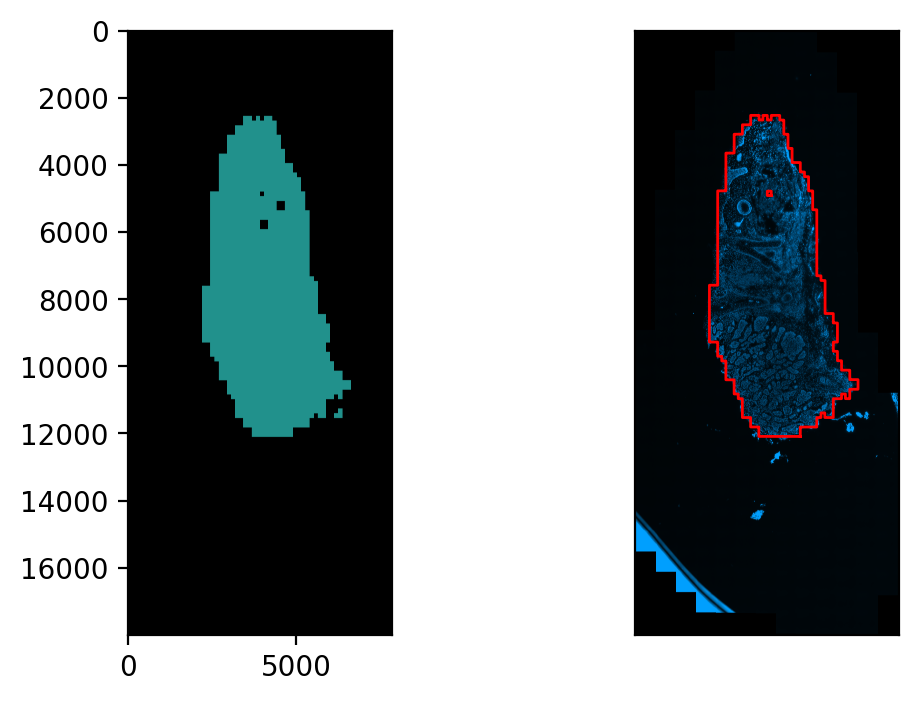

In [11]:
strish_bcc_e15_s1.plot_tissue_window_contour(extend_margin=3, window_area_threshold=68845)


In [12]:
tissue_contours = strish_bcc_e15_s1.contours

In [13]:
strish_bcc_e15_s1.var_names = list(signal2rna_r1.values())
filtered_strish_bcc_e15_s1 = strish_bcc_e15_s1.preprocess_filter_size_shape(column= 'Nucleus: Area',
                                                                         lower=0.01,
                                                                         upper=0.95)
marker_rna = ['CSF1R', 'IL34', 'THY1']
filtered_strish_bcc_e15_s1 = filtered_strish_bcc_e15_s1[:,marker_rna]

/home/s4596423/env/ultimate_env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
merge_count_values = pd.read_csv('Cells_count_per_window.csv', index_col=0)
merge_count_values

,CSF1R+,IL34+,THY1+,CD207+,ITGAM+
"1964,10118,2946,11242",1,50,10,28,48
"1964,2248,2946,3372",0,6,0,0,4
"1964,5059,2455,5621",0,7,0,1,11
"1964,5621,2455,6183",2,1,0,13,31
"1964,6183,2455,6745",6,42,1,36,46
...,...,...,...,...,...
"6260,10258,6382,10398",1,16,1,0,7
"6260,10399,6382,10539",1,33,0,10,14
"6260,10539,6382,10679",3,23,5,10,7
"6384,10118,6875,10680",0,21,8,10,14


In [15]:
merge_count_values
lr_cols = pairs(merge_count_values.columns)
print(len(lr_cols))
lr_cols

10


['CSF1R_IL34',
 'CSF1R_THY1',
 'CSF1R_CD207',
 'CSF1R_ITGAM',
 'IL34_THY1',
 'IL34_CD207',
 'IL34_ITGAM',
 'THY1_CD207',
 'THY1_ITGAM',
 'CD207_ITGAM']

In [32]:
scores = pd.DataFrame(index=merge_count_values.index.values, columns=lr_cols)

In [33]:
for col in scores:
    sender, receiver = col.split('_')
    sender += '+'
    receiver += '+'
    scores[col] = (merge_count_values[sender] + merge_count_values[receiver])/merge_count_values.sum(axis =1)
    scores[col][merge_count_values[sender] == 0] = 0
    scores[col][merge_count_values[receiver] == 0] = 0

scores.reset_index(inplace=True)
scores

/state/partition1/pbs/tmpdir/pbs.704325.tinmgr2/ipykernel_14039/2343925984.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[col][merge_count_values[sender] == 0] = 0
/state/partition1/pbs/tmpdir/pbs.704325.tinmgr2/ipykernel_14039/2343925984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[col][merge_count_values[receiver] == 0] = 0


,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM
0,"1964,10118,2946,11242",0.372263,0.080292,0.211679,0.357664,0.437956,0.569343,0.715328,0.277372,0.423358,0.554745
1,"1964,2248,2946,3372",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,"1964,5059,2455,5621",0.000000,0.000000,0.000000,0.000000,0.000000,0.421053,0.947368,0.000000,0.000000,0.631579
3,"1964,5621,2455,6183",0.063830,0.000000,0.319149,0.702128,0.000000,0.297872,0.680851,0.000000,0.000000,0.936170
4,"1964,6183,2455,6745",0.366412,0.053435,0.320611,0.396947,0.328244,0.595420,0.671756,0.282443,0.358779,0.625954
...,...,...,...,...,...,...,...,...,...,...,...
1216,"6260,10258,6382,10398",0.680000,0.080000,0.000000,0.320000,0.680000,0.000000,0.920000,0.000000,0.320000,0.000000
1217,"6260,10399,6382,10539",0.586207,0.000000,0.189655,0.258621,0.000000,0.741379,0.810345,0.000000,0.000000,0.413793
1218,"6260,10539,6382,10679",0.541667,0.166667,0.270833,0.208333,0.583333,0.687500,0.625000,0.312500,0.250000,0.354167
1219,"6384,10118,6875,10680",0.000000,0.000000,0.000000,0.000000,0.547170,0.584906,0.660377,0.339623,0.415094,0.452830


In [34]:
target_lr = 'CSF1R_IL34'
background_table = scores[['index'] + lr_cols].drop(columns=target_lr)
all_obs_windows = scores[[target_lr]].values
scores['p_value_'+target_lr] = 0.0
for index, row in background_table.iterrows():
    background_windows_row = row[1:].values
    single_total = list(all_obs_windows) + list(background_windows_row)
    p_value = sum(single_total >= scores.loc[index,target_lr])/len(single_total)
#     if p_value == 0: 
#         print(row)
    scores.loc[index,'p_value_'+target_lr] =  p_value
    scores.loc[index,'log10p_'+target_lr] =  -np.log10(p_value)

/state/partition1/pbs/tmpdir/pbs.704325.tinmgr2/ipykernel_14039/2358211115.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_value = sum(single_total >= scores.loc[index,target_lr])/len(single_total)


In [31]:
# background_table

In [32]:
# len(single_total)

In [35]:
scores

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34
0,"1964,10118,2946,11242",0.372263,0.080292,0.211679,0.357664,0.437956,0.569343,0.715328,0.277372,0.423358,0.554745,0.249593,0.602767
1,"1964,2248,2946,3372",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-0.000000
2,"1964,5059,2455,5621",0.000000,0.000000,0.000000,0.000000,0.000000,0.421053,0.947368,0.000000,0.000000,0.631579,1.000000,-0.000000
3,"1964,5621,2455,6183",0.063830,0.000000,0.319149,0.702128,0.000000,0.297872,0.680851,0.000000,0.000000,0.936170,0.437398,0.359123
4,"1964,6183,2455,6745",0.366412,0.053435,0.320611,0.396947,0.328244,0.595420,0.671756,0.282443,0.358779,0.625954,0.255285,0.592975
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,"6260,10258,6382,10398",0.680000,0.080000,0.000000,0.320000,0.680000,0.000000,0.920000,0.000000,0.320000,0.000000,0.037398,1.427147
1217,"6260,10399,6382,10539",0.586207,0.000000,0.189655,0.258621,0.000000,0.741379,0.810345,0.000000,0.000000,0.413793,0.077236,1.112182
1218,"6260,10539,6382,10679",0.541667,0.166667,0.270833,0.208333,0.583333,0.687500,0.625000,0.312500,0.250000,0.354167,0.104878,0.979315
1219,"6384,10118,6875,10680",0.000000,0.000000,0.000000,0.000000,0.547170,0.584906,0.660377,0.339623,0.415094,0.452830,1.000000,-0.000000


In [36]:
scores.loc[0,target_lr]

0.3722627737226277

In [37]:
scores['sig_'+target_lr] = np.where(scores['p_value_'+target_lr] < 0.05, True, False )

In [38]:
print(scores[scores['sig_'+target_lr] == True].shape)
scores[scores['sig_'+target_lr] == True]

(56, 14)


,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34
99,"2822,7166,2944,7306",0.666667,0.000000,0.633333,0.633333,0.000000,0.366667,0.366667,0.000000,0.000000,0.333333,0.048780,1.311754,True
100,"2822,7307,2944,7447",0.677419,0.000000,0.532258,0.596774,0.000000,0.403226,0.467742,0.000000,0.000000,0.322581,0.039024,1.408664,True
126,"2946,5480,3068,5620",0.857143,0.000000,0.000000,0.857143,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.010569,1.975962,True
133,"2946,6604,3068,6744",1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002439,2.612784,True
134,"2946,6745,3068,6885",0.933333,0.000000,0.666667,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.004878,2.311754,True
138,"2946,7307,3068,7447",0.772727,0.522727,0.636364,0.568182,0.295455,0.409091,0.340909,0.159091,0.090909,0.204545,0.019512,1.709694,True
139,"2946,7447,3068,7587",0.833333,0.861111,0.861111,0.000000,0.138889,0.138889,0.000000,0.166667,0.000000,0.000000,0.013821,1.859456,True
144,"2946,8431,3068,8571",0.941176,0.000000,0.000000,0.235294,0.000000,0.000000,0.823529,0.000000,0.000000,0.000000,0.004065,2.390935,True
173,"3068,6604,3190,6744",0.727273,0.727273,0.636364,0.000000,0.363636,0.272727,0.000000,0.272727,0.000000,0.000000,0.027642,1.558426,True
175,"3068,6885,3190,7025",0.714286,0.642857,0.714286,0.642857,0.214286,0.285714,0.214286,0.214286,0.142857,0.214286,0.030081,1.521703,True


In [68]:
csf1r_il34 = scores[scores['sig_CSF1R_IL34'] == True]
csf1r_il34.shape

(56, 17)

In [40]:
range_areas = [17080, 68845, 275942, 1103768, 4415072]

In [41]:
boxes_coords2 = csf1r_il34['index'].values
all_score_rects2 = list()
for box_coord in  boxes_coords2:
    int_box = [int(i) for i in box_coord.split(',')]
    if (int_box[2]-int_box[0])*(int_box[3]-int_box[1]) < range_areas[1]: # off tissue area 
        all_score_rects2.append(int_box)
print(len(all_score_rects2))
heat_scores2 = csf1r_il34['log10p_CSF1R_IL34'].values
print(heat_scores2)

56
[1.31175386 1.40866387 1.97596176 2.61278386 2.31175386 1.70969387
 1.85945619 2.39093511 1.55842619 1.52170339 1.6919651  1.36562924
 2.48784512 1.57139117 2.61278386 1.44645243 1.81115151 2.08990511
 2.01072387 1.53360261 1.30457528 1.31175386 1.64274708 1.65854135
 1.48784512 1.72817728 1.30457528 1.51012151 1.41780725 1.70969387
 1.30457528 1.54583707 1.85945619 1.53360261 1.58475513 1.64274708
 2.61278386 1.94377708 1.38233494 2.01072387 1.46665582 1.85945619
 2.01072387 1.64274708 1.44645243 1.58475513 2.18681512 1.76768582
 1.39970903 1.88578513 1.44645243 1.41780725 1.51012151 1.78887512
 1.38233494 1.42714728]


In [42]:
heat_colors = np.array(map_heat_values2colors(heat_scores2))
heat_colors = heat_colors * 255

In [43]:
x0, x1, y0, y1 = 2525, 12089, 2205, 6633

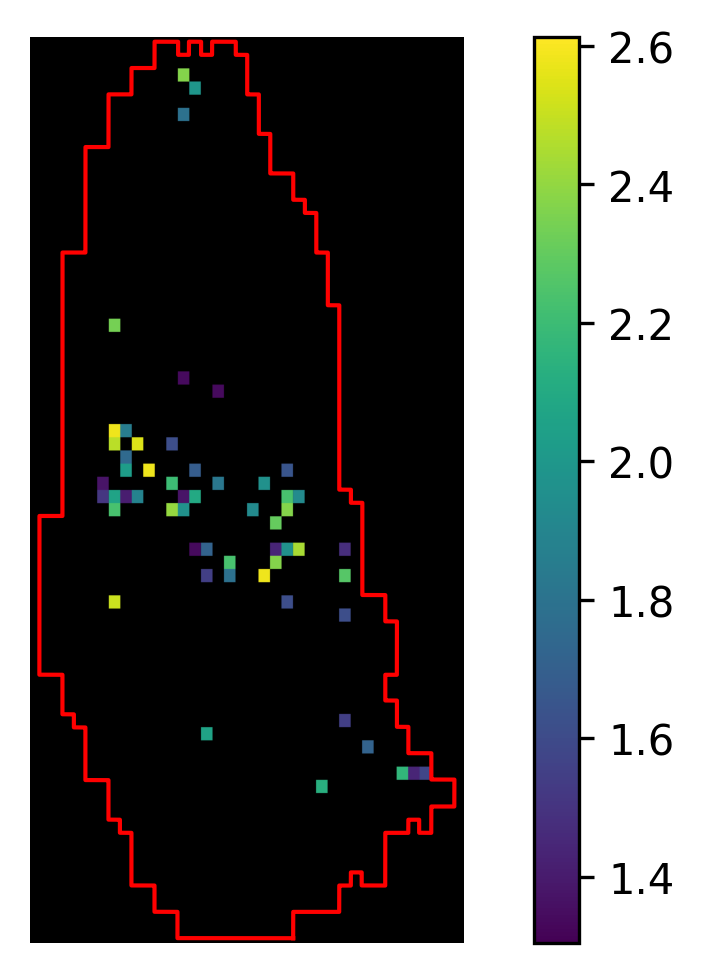

In [49]:
tempt_img = np.zeros_like(filtered_strish_bcc_e15_s1.ref_image)
colocalised_heatmap = draw_rectangles_heat(tempt_img, 
                                           all_score_rects2, 
                                           heat_colors)
fig, ax = plt.subplots(dpi=300)
scores_range =  np.array(heat_scores2)
map_color = ax.imshow(colocalised_heatmap, vmax=scores_range.max(), vmin=scores_range.min())
fig.colorbar(map_color, orientation='vertical')
if len(tissue_contours) != 0:
    for contour in tissue_contours[0:1]:
        ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
# ax.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
plt.ylim(x0-50,x1+50)
plt.xlim(y0-100,y1+100)
ax.axis('off')
plt.gca().invert_yaxis()
# plt.savefig("0127_After_stat_test.pdf")

In [50]:
target_lr2 = 'THY1_ITGAM'
background_table = scores[['index'] + lr_cols].drop(columns=target_lr2)
all_obs_windows = scores[[target_lr2]].values
scores['p_value_'+target_lr2] = 0.0
for index, row in background_table.iterrows():
    background_windows_row = row[1:].values
    single_total = list(all_obs_windows) + list(background_windows_row)
    p_value = sum(single_total >= scores.loc[index,target_lr2])/len(single_total)
    if p_value == 0: 
        print(row)
    scores.loc[index,'p_value_'+target_lr2] =  p_value
    scores.loc[index,'log10p_'+target_lr2] =  -np.log10(p_value)
    


/state/partition1/pbs/tmpdir/pbs.704325.tinmgr2/ipykernel_14039/4004712731.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_value = sum(single_total >= scores.loc[index,target_lr2])/len(single_total)


In [51]:
# background_table

In [52]:
# print(all_obs_windows.min(),all_obs_windows.max())
# print(scores['p95_THY1_ITGAM'].values.min(), scores['p95_THY1_ITGAM'].values.max())
scores

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM
0,"1964,10118,2946,11242",0.372263,0.080292,0.211679,0.357664,0.437956,0.569343,0.715328,0.277372,0.423358,0.554745,0.249593,0.602767,False,0.316260,0.499956
1,"1964,2248,2946,3372",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,False,1.000000,-0.000000
2,"1964,5059,2455,5621",0.000000,0.000000,0.000000,0.000000,0.000000,0.421053,0.947368,0.000000,0.000000,0.631579,1.000000,-0.000000,False,1.000000,-0.000000
3,"1964,5621,2455,6183",0.063830,0.000000,0.319149,0.702128,0.000000,0.297872,0.680851,0.000000,0.000000,0.936170,0.437398,0.359123,False,1.000000,-0.000000
4,"1964,6183,2455,6745",0.366412,0.053435,0.320611,0.396947,0.328244,0.595420,0.671756,0.282443,0.358779,0.625954,0.255285,0.592975,False,0.342276,0.465623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,"6260,10258,6382,10398",0.680000,0.080000,0.000000,0.320000,0.680000,0.000000,0.920000,0.000000,0.320000,0.000000,0.037398,1.427147,True,0.357724,0.446452
1217,"6260,10399,6382,10539",0.586207,0.000000,0.189655,0.258621,0.000000,0.741379,0.810345,0.000000,0.000000,0.413793,0.077236,1.112182,False,1.000000,-0.000000
1218,"6260,10539,6382,10679",0.541667,0.166667,0.270833,0.208333,0.583333,0.687500,0.625000,0.312500,0.250000,0.354167,0.104878,0.979315,False,0.404878,0.392676
1219,"6384,10118,6875,10680",0.000000,0.000000,0.000000,0.000000,0.547170,0.584906,0.660377,0.339623,0.415094,0.452830,1.000000,-0.000000,False,0.319512,0.495513


In [53]:
scores[scores[target_lr2]==1]

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM
161,"3068,4355,3190,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
288,"3437,4918,3559,5058",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
327,"3559,4355,3681,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
329,"3559,4637,3681,4777",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
330,"3559,4778,3681,4918",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,"5278,5340,5400,5480",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
1067,"5278,5480,5400,5620",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
1075,"5278,6604,5400,6744",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026
1081,"5278,7447,5400,7587",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026


In [54]:
target_lr2

'THY1_ITGAM'

In [56]:
len(single_total)

1230

In [54]:
scores.loc[1,target_lr2]

0.0

In [55]:
scores['sig_'+target_lr2] = np.where(scores['p_value_'+target_lr2] < 0.12, True, False )


In [56]:
print(scores[scores['sig_'+target_lr2] == True].shape)
scores[scores['sig_'+target_lr2] == True]

(147, 17)


,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM,sig_THY1_ITGAM
161,"3068,4355,3190,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
288,"3437,4918,3559,5058",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
327,"3559,4355,3681,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
329,"3559,4637,3681,4777",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
330,"3559,4778,3681,4918",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,"5278,5340,5400,5480",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
1067,"5278,5480,5400,5620",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
1075,"5278,6604,5400,6744",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
1081,"5278,7447,5400,7587",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True


In [57]:
target_lr2

'THY1_ITGAM'

In [58]:
thy1_itgam = scores[scores['sig_THY1_ITGAM'] == True]
thy1_itgam.head()

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM,sig_THY1_ITGAM
161,"3068,4355,3190,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
288,"3437,4918,3559,5058",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
327,"3559,4355,3681,4495",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
329,"3559,4637,3681,4777",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True
330,"3559,4778,3681,4918",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,False,0.112195,0.950026,True


In [59]:
boxes_coords3 = thy1_itgam['index'].values
all_score_rects3 = list()
for box_coord in  boxes_coords3:
    int_box = [int(i) for i in box_coord.split(',')]
    if (int_box[2]-int_box[0])*(int_box[3]-int_box[1]) < range_areas[1]: # off tissue area 
        all_score_rects3.append(int_box)
print(len(all_score_rects3))
heat_scores3 = thy1_itgam['log10p_THY1_ITGAM'].values
print(heat_scores3)

142
[0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.94689031 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.93154262
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.92258778 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603
 0.95002603 0.95002603 0.95002603 0.95002603 0.95002603 0.

In [60]:
heat_colors3 = np.array(map_heat_values2colors(heat_scores3))
heat_colors3 = heat_colors3 * 255

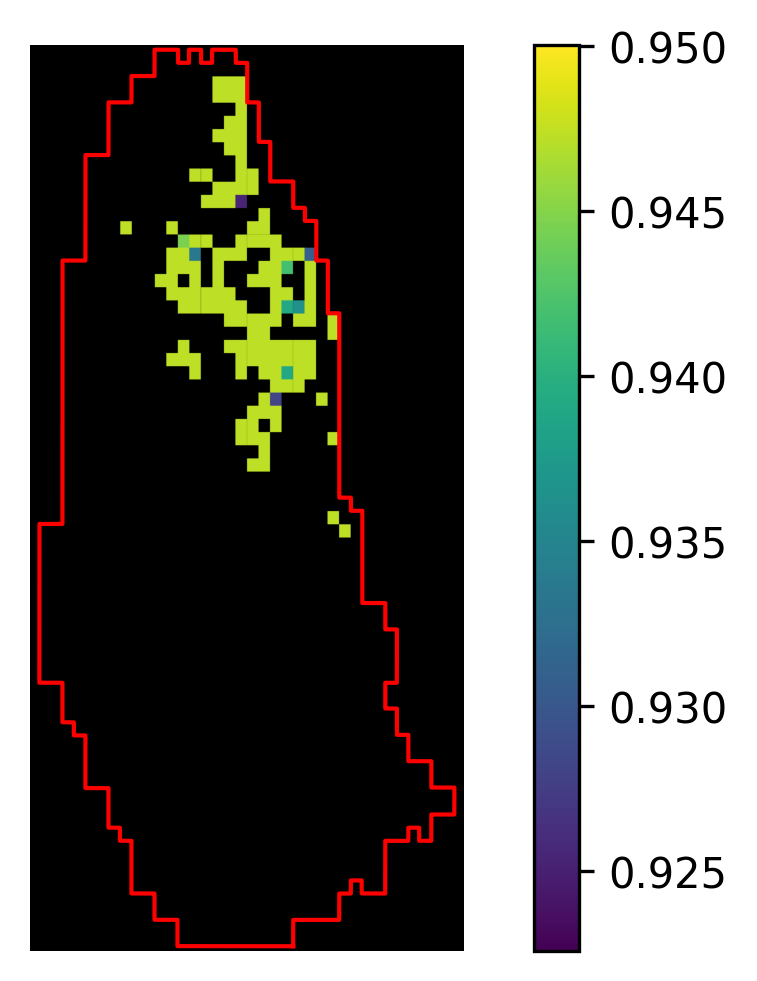

In [62]:
tempt_img = np.zeros_like(filtered_strish_bcc_e15_s1.ref_image)
colocalised_heatmap = draw_rectangles_heat(tempt_img, 
                                           all_score_rects3, 
                                           heat_colors3)
fig, ax = plt.subplots(dpi=300)
scores_range =  np.array(heat_scores3)
map_color = ax.imshow(colocalised_heatmap, vmax=scores_range.max(), vmin=scores_range.min())
fig.colorbar(map_color, orientation='vertical')
if len(tissue_contours) != 0:
    for contour in tissue_contours[0:1]:
        ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
# ax.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
plt.ylim(x0-50,x1+50)
plt.xlim(y0-100,y1+100)
ax.axis('off')
plt.gca().invert_yaxis()
plt.savefig("0223_THY1_ITGAM_After_stat_test.pdf")

In [63]:
scores

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM,sig_THY1_ITGAM
0,"1964,10118,2946,11242",0.372263,0.080292,0.211679,0.357664,0.437956,0.569343,0.715328,0.277372,0.423358,0.554745,0.249593,0.602767,False,0.316260,0.499956,False
1,"1964,2248,2946,3372",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,False,1.000000,-0.000000,False
2,"1964,5059,2455,5621",0.000000,0.000000,0.000000,0.000000,0.000000,0.421053,0.947368,0.000000,0.000000,0.631579,1.000000,-0.000000,False,1.000000,-0.000000,False
3,"1964,5621,2455,6183",0.063830,0.000000,0.319149,0.702128,0.000000,0.297872,0.680851,0.000000,0.000000,0.936170,0.437398,0.359123,False,1.000000,-0.000000,False
4,"1964,6183,2455,6745",0.366412,0.053435,0.320611,0.396947,0.328244,0.595420,0.671756,0.282443,0.358779,0.625954,0.255285,0.592975,False,0.342276,0.465623,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,"6260,10258,6382,10398",0.680000,0.080000,0.000000,0.320000,0.680000,0.000000,0.920000,0.000000,0.320000,0.000000,0.037398,1.427147,True,0.357724,0.446452,False
1217,"6260,10399,6382,10539",0.586207,0.000000,0.189655,0.258621,0.000000,0.741379,0.810345,0.000000,0.000000,0.413793,0.077236,1.112182,False,1.000000,-0.000000,False
1218,"6260,10539,6382,10679",0.541667,0.166667,0.270833,0.208333,0.583333,0.687500,0.625000,0.312500,0.250000,0.354167,0.104878,0.979315,False,0.404878,0.392676,False
1219,"6384,10118,6875,10680",0.000000,0.000000,0.000000,0.000000,0.547170,0.584906,0.660377,0.339623,0.415094,0.452830,1.000000,-0.000000,False,0.319512,0.495513,False


In [65]:
raw_thy1_itgam = scores[scores['THY1_ITGAM'] != 0]
raw_thy1_itgam

,index,CSF1R_IL34,CSF1R_THY1,CSF1R_CD207,CSF1R_ITGAM,IL34_THY1,IL34_CD207,IL34_ITGAM,THY1_CD207,THY1_ITGAM,CD207_ITGAM,p_value_CSF1R_IL34,log10p_CSF1R_IL34,sig_CSF1R_IL34,p_value_THY1_ITGAM,log10p_THY1_ITGAM,sig_THY1_ITGAM
0,"1964,10118,2946,11242",0.372263,0.080292,0.211679,0.357664,0.437956,0.569343,0.715328,0.277372,0.423358,0.554745,0.249593,0.602767,False,0.316260,0.499956,False
4,"1964,6183,2455,6745",0.366412,0.053435,0.320611,0.396947,0.328244,0.595420,0.671756,0.282443,0.358779,0.625954,0.255285,0.592975,False,0.342276,0.465623,False
6,"1964,7307,2455,7869",0.210191,0.121019,0.401274,0.573248,0.127389,0.407643,0.579618,0.318471,0.490446,0.770701,0.390244,0.408664,False,0.288618,0.539677,False
10,"1964,8712,2209,8993",0.161765,0.058824,0.220588,0.647059,0.161765,0.323529,0.750000,0.220588,0.647059,0.808824,0.415447,0.381484,False,0.223577,0.650572,False
11,"1964,8994,2209,9275",0.223881,0.179104,0.283582,0.447761,0.313433,0.417910,0.582090,0.373134,0.537313,0.641791,0.375610,0.425263,False,0.263415,0.579360,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,"6260,10118,6382,10258",0.000000,0.000000,0.000000,0.000000,0.625000,0.000000,0.875000,0.000000,0.500000,0.000000,1.000000,-0.000000,False,0.286992,0.542130,False
1216,"6260,10258,6382,10398",0.680000,0.080000,0.000000,0.320000,0.680000,0.000000,0.920000,0.000000,0.320000,0.000000,0.037398,1.427147,True,0.357724,0.446452,False
1218,"6260,10539,6382,10679",0.541667,0.166667,0.270833,0.208333,0.583333,0.687500,0.625000,0.312500,0.250000,0.354167,0.104878,0.979315,False,0.404878,0.392676,False
1219,"6384,10118,6875,10680",0.000000,0.000000,0.000000,0.000000,0.547170,0.584906,0.660377,0.339623,0.415094,0.452830,1.000000,-0.000000,False,0.319512,0.495513,False


In [74]:
boxes_coords4 = raw_thy1_itgam['index'].values
selected_indices = list()
all_score_rects4 = list()
for box_coord in  boxes_coords4:
    int_box = [int(i) for i in box_coord.split(',')]
    if (int_box[2]-int_box[0])*(int_box[3]-int_box[1]) < range_areas[1]: # off tissue area 
        all_score_rects4.append(int_box)
        selected_indices.append(box_coord)
print(len(all_score_rects4))
heat_scores4 = raw_thy1_itgam[ raw_thy1_itgam['index'].isin(selected_indices)]['THY1_ITGAM'].values
print(len(heat_scores4))

506
506


In [75]:
heat_colors4 = np.array(map_heat_values2colors(heat_scores4))
heat_colors4 = heat_colors4 * 255

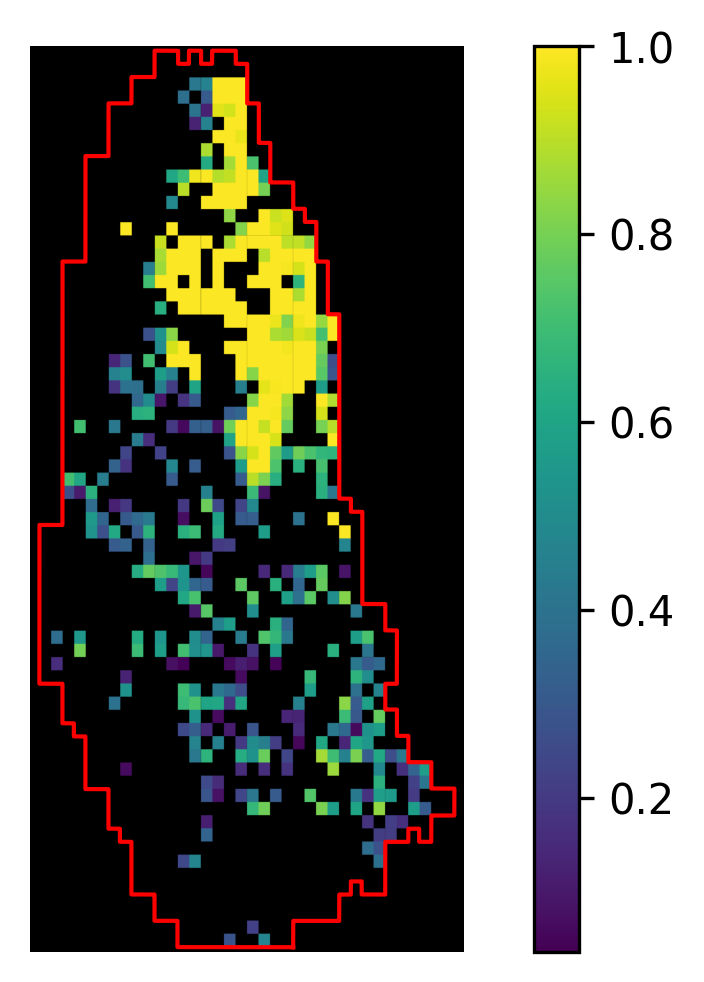

In [76]:
tempt_img = np.zeros_like(filtered_strish_bcc_e15_s1.ref_image)
colocalised_heatmap = draw_rectangles_heat(tempt_img, 
                                           all_score_rects4, 
                                           heat_colors4)
fig, ax = plt.subplots(dpi=300)
scores_range =  np.array(heat_scores4)
map_color = ax.imshow(colocalised_heatmap, vmax=scores_range.max(), vmin=scores_range.min())
fig.colorbar(map_color, orientation='vertical')
if len(tissue_contours) != 0:
    for contour in tissue_contours[0:1]:
        ax.plot(contour[:, 1], contour[:, 0], 'r',linewidth=1.0)
# ax.axis('off')
# ax.set_xticks([])
# ax.set_yticks([])
plt.ylim(x0-50,x1+50)
plt.xlim(y0-100,y1+100)
ax.axis('off')
plt.gca().invert_yaxis()
plt.savefig("0223_THY1_ITGAM_Before_stat_test.pdf")